## Physics 453: Quantum Mechanics - Computational Assignment: The Infinite Square Well

The Infinite Square Well (ISW) is one of the few problems in quantum mechanics that can be easily solved on a chalkboard. This makes it the usual starting place for introducing quantum concepts like energy levels, superposition, and stationary states.  In addition, having the "exact" answers makes the infinite square well problem a great introductory computational problem, since we can easily check that our program is working correctly!

In this assignment we will:
1. Plot the spatial parts of infinite square well eigenstates
* Animate the time dependence of the ISW eigenstates
* Form a superposition of ISW eigenstates and animate its time evolution

Each segment of code you have to modify is marked "Question".

### Infinite Square Well Review

Let's review the equations we'll need. According to Griffiths, for an ISW located between $x=0$ and $x=a$, the solutions of the time-independent Schrodinger equation are
$$\psi_n(x)=\sqrt{\frac{2}{a}}\sin \left( \frac{n\pi}{a}x \right)$$
$$E_n = \frac{n^2\pi^2\hbar^2}{2ma^2}$$
$$\Psi_n(x,t)=\psi_n(x)e^{-iE_nt/\hbar}$$

Therefore, an arbitrary state in an ISW can be written as a superposition of these eigenstates.
$$\Psi(x,t)=\sum_{n=1}^{\infty} c_n \psi_n(x)e^{-iE_nt/\hbar}$$
$$c_n=\int \psi_n^*(x) \Psi(x,t)dx$$
$$\sum_{n=0}^{\infty}|c_n|^2=1$$

### Time Scales and Small Numbers

Computers are great at math, but they often have trouble with very large or very small numbers.  We'd also like to plot things at a reasonable scale, sparing the reader from axes with numbers like $1.6\times10^{-23}$.  Planck's constant ($\hbar$), particle masses ($m$), and atomic distances ($a$) are very small numbers in MKS units, and we'd like to get a sense of the scales we're working with before programming away.  If you look at the above formulas, you'll see that the energy phase factor sets the time scale.  
$$\exp\left( -i E_n t/ \hbar\right) = \exp\left( -i \frac{n^2 \pi^2 \hbar}{2ma^2}t \right)$$

#### Question 1
Suppose an electron is confined to an ISW with $a=1 \unicode{x212B}= 1\times 10^{-10}m$.  What is the period $T$ of the phase factor for the ground state?

In [1]:
import numpy  #We need pi now, and we'll need more NumPy stuff later later
n = 1         #We want the ground state
a = 1e-10     #Well width
m = 9.1e-31   #Electron mass
hbar = 1.0545718e-34    #Planck's constant divided by 2pi
T = 2*numpy.pi / (n**2 * numpy.pi**2 * hbar / (2*m*a**2))    #Change this line to calculate the period, T
print("The period is T =",T, " seconds")

The period is T = 1.0986904691638807e-16  seconds


Check: The correct answer is $T\approx 1.1\times10^{-16} s$.

We see that the typical time scales for an actual system are very small, so we'll choose units that let us work with reasonable numbers.  For the rest of the notebook, let's work in a new time scale, $$\tau = \frac{\hbar}{ma^2}t$$ and furthermore say that $a=1m$.

### Programming the Eigenstates

Let's write some functions to get the eigenstates of the ISW as NumPy arrays.  This will make them easy to plot and manipulate.  First we need an array that represents our space, $x=0$ to $x=a=1$.

In [2]:
spacing = 0.01     #If you want more spatial resolution, you could decrease the spacing 
x = numpy.arange(0, 1, spacing)   
N = len(x)         #Number of coordinates

#### Question 2
Write a function that takes $x$, the spatial locations, and $n$, the eigenstate index, and returns the spatial part of the $n^{th}$ eigenstate, $\psi_n(x)$.  I wrote most of the function for you, but it's not quite right...

In [3]:
def psi_n_x(x,n):
    return numpy.sqrt(2)*numpy.sin(n*numpy.pi*x)    #Change this line to return the right function!

Okay, now let's check our function for $\psi_n(x)$.  We'll do this in two ways, 
1. Checking that it is properly normalized 
* Plot it to make sure the boundary conditions and nodes are correct

Here is a function that will take a function (in the form of a NumPy array), and return the integral of it's square, or the norm.  

In [4]:
def norm(dx, f):
    return dx*numpy.dot(f,numpy.conjugate(f))

#### Question 3
The following code will calculate the norm of the $n^{th}$ eigenstate and plot both the wavefunction and the probability distribution.  Change $n$ to check a few excited states.  Does it look like your $\psi_n(x)$ is correct?  Write your reasoning in the Markdown cell beneath the plots.

Norm of psi_test =  1.0


<IPython.core.display.Javascript object>


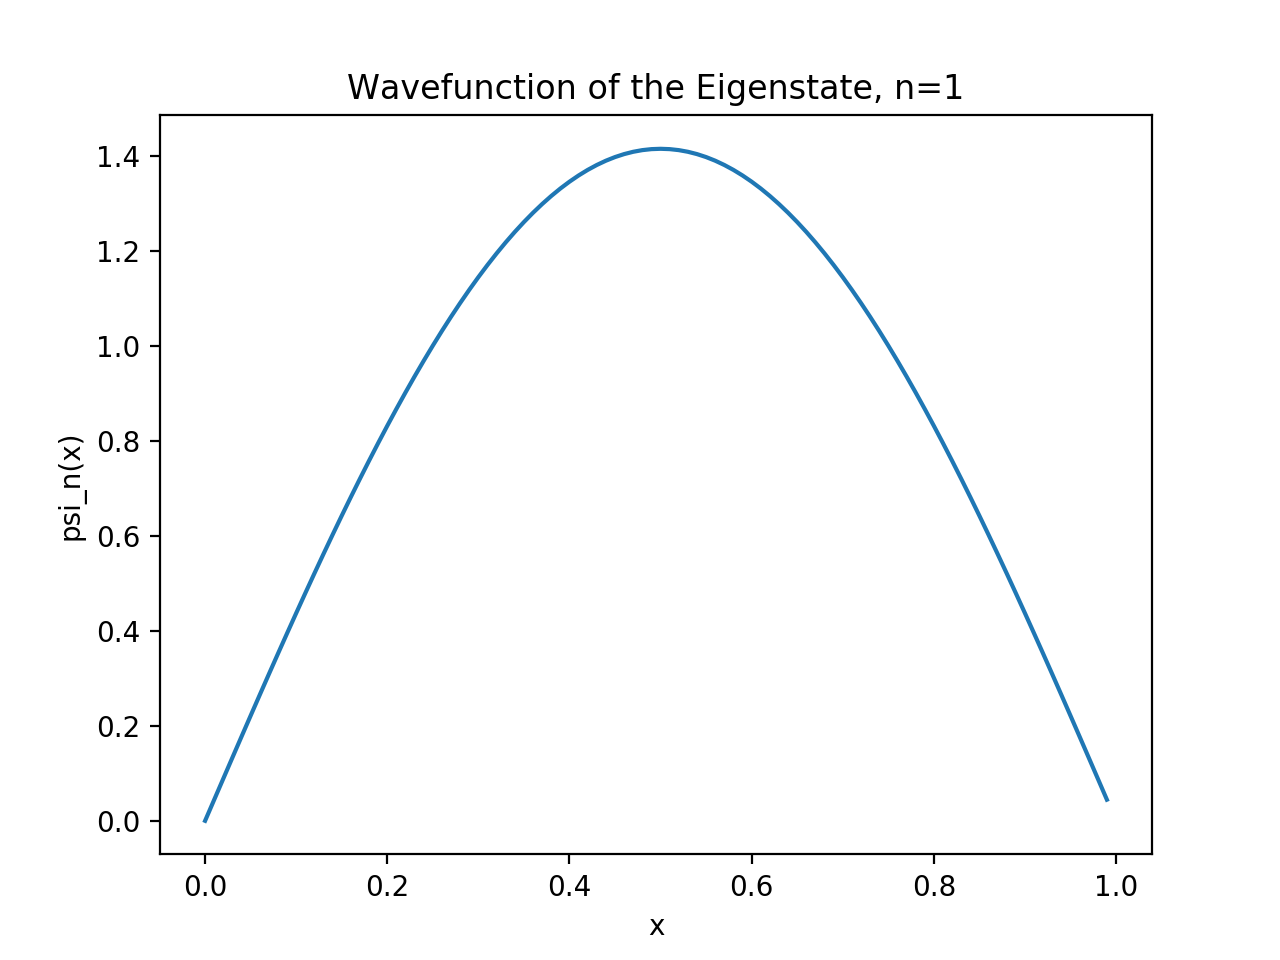

<IPython.core.display.Javascript object>


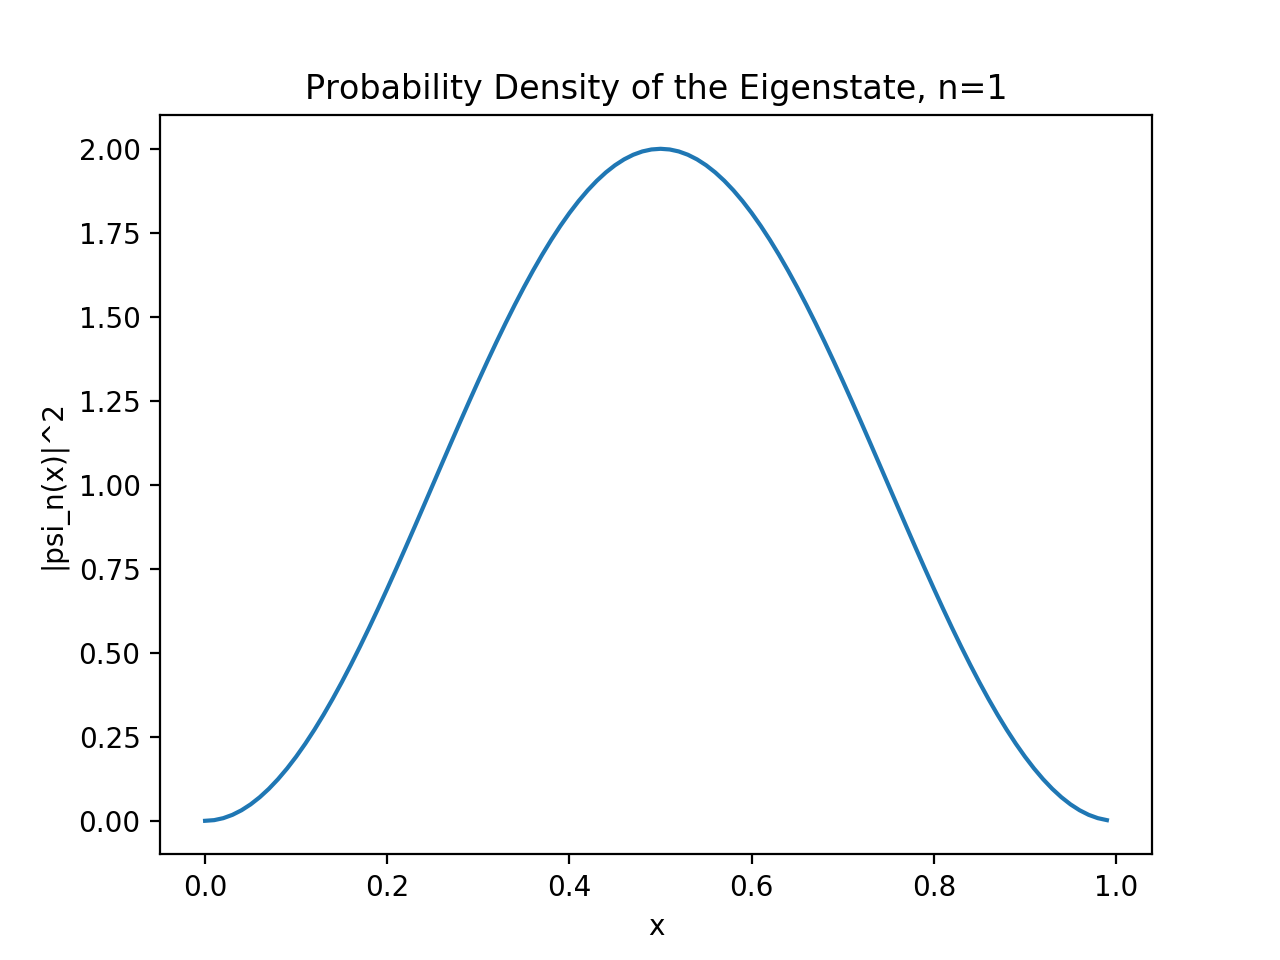

In [5]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt 

n=1     # Change this line to test different eigenstates
psi_test = psi_n_x(x,n)
print("Norm of psi_test = ",norm(spacing, psi_test))

plt.plot(x, psi_test)
plt.xlabel("x")
plt.ylabel("psi_n(x)")
plt.title("Wavefunction of the Eigenstate, n="+str(n))

plt.figure()
plt.plot(x, psi_test*numpy.conjugate(psi_test))    #Remember that the norm is conjugate(psi)*psi!
plt.xlabel("x")
plt.ylabel("|psi_n(x)|^2")
plt.title("Probability Density of the Eigenstate, n="+str(n))
plt.show()

#### Write your answer to Question 3 here!

### Superpositions

Okay, now we can move on to something a bit more interesting: arbitrary superpositions of the eigenstates in the Infinite Square.  With our new time scale, $\tau$, these superpositions look like:

$$\Psi(x,\tau)=\sum_{n=1}^{\infty} c_n \psi_n(x,\tau)$$
$$\psi_n(x,\tau)=\psi_n(x)e^{-in^2\pi^2\tau/2}$$
$$\sum_{n=0}^{\infty}|c_n|^2=1$$

What we're going to do now is write some code that will take a set of coefficients, $c_n$, and animate the time evolution of the wavefunction and probability distribution of $\Psi(x,\tau)$.

### Getting $\psi_n(x,\tau)$
Quick question: Is $\psi_n(x)$ an eigenstate wavefunction? No! Remember that the actual wavefunction, $\psi_n(x,t)$, is given by $\psi_n(x)$ times the time-dependent phase factor.  This is critically important for the time evolution of superpositions, because the phase factors are what give rise to interesting time dependence via interference. (It's also a favorite test question :-)

Here's a function which, when given $x$, $n$, and $\tau$ will return $\psi_n(x,\tau)$. Note that we save ourselves some work by reusing our function to calculate $\psi_n(x)$.

In [6]:
def psi_n_x_t(x, n, t):
    return psi_n_x(x,n)*numpy.exp(-1j*n**2 * numpy.pi**2 * t /2)

### Getting $\Psi(x,\tau)$
Now we are going to write a function that will take $x$, $\tau$, and the eigenstate coefficients $c_n$ (as a NumPy array) as inputs, and return the superposition wavefunction at time $\tau$, $\Psi(x,\tau)$.

#### Question 4
Complete the function below, "wavefunction(x,t,cn)", so that it returns $\Psi(x,\tau)$.

In [7]:
def wavefunction(x, t, cn):
    
    # First we check that the coefficients obey the rule that total probability = 1
    total_probability = numpy.dot(numpy.conjugate(cn),cn)
    if(not abs(total_probability - 1) < 1e-6):    
        print("Error! Sum of the conefficients squared does not equal 1! Total Probability =", total_probability)
        return
    
    # Now we create a blank wavefunction.  We will add each eigenstate to it, weighted by the proper coefficients.
    wf = numpy.zeros_like(x)
    for n in range(0,len(cn)):
        wf = wf + cn[n]*psi_n_x_t(x, n+1, t)   # This is the line you need to fix!
        
    return wf

### Animating $\Psi(x,\tau)$
Now we can animate the time evolution of an arbitrary superposition! We just need to specify the coefficients $c_n$.  Here, we'll start off with an equal superposition of energy eigenstates $n=1,2,4,6$.  But you can create any mixture you like, as long as they obey $\sum_n |c_n|^2=1$! You can include higher energy eigenstates by adding more elements to the $c_n$ array.

In [8]:
cn=numpy.array([numpy.sqrt(1./4), numpy.sqrt(1./4),0,numpy.sqrt(1./4),0, numpy.sqrt(1./4),0])
#cn=numpy.array([0, 0,1,0,0, 0,0])
#cn=numpy.array([0, 0, 1./3**3, 1./3**3, 1./5**3, 0, 1./7**3, 0])
#cn = cn / numpy.sqrt(numpy.dot(numpy.conjugate(cn),cn))
#cn=numpy.array([1, 0,0,0, 0,0])

Below is the code to animate $\Psi(x,\tau)$.  As is often the case, the code to do this takes up a lot of space, but it's just composed of a bunch of simple commands. (Ex. Setting axis labels, specifying the ranges, etc.) When you execute the cell, the code will use your "wavefunction(x,t,cn)" function to make the animation.  Three animations will appear, for $Re[\Psi(x,\tau)]$, $Im[\Psi(x,\tau)]$, and the probability density, $|\Psi(x,\tau)|^2$. 

Note: You press the power button on the top right of the animation to make it stop!

<IPython.core.display.Javascript object>


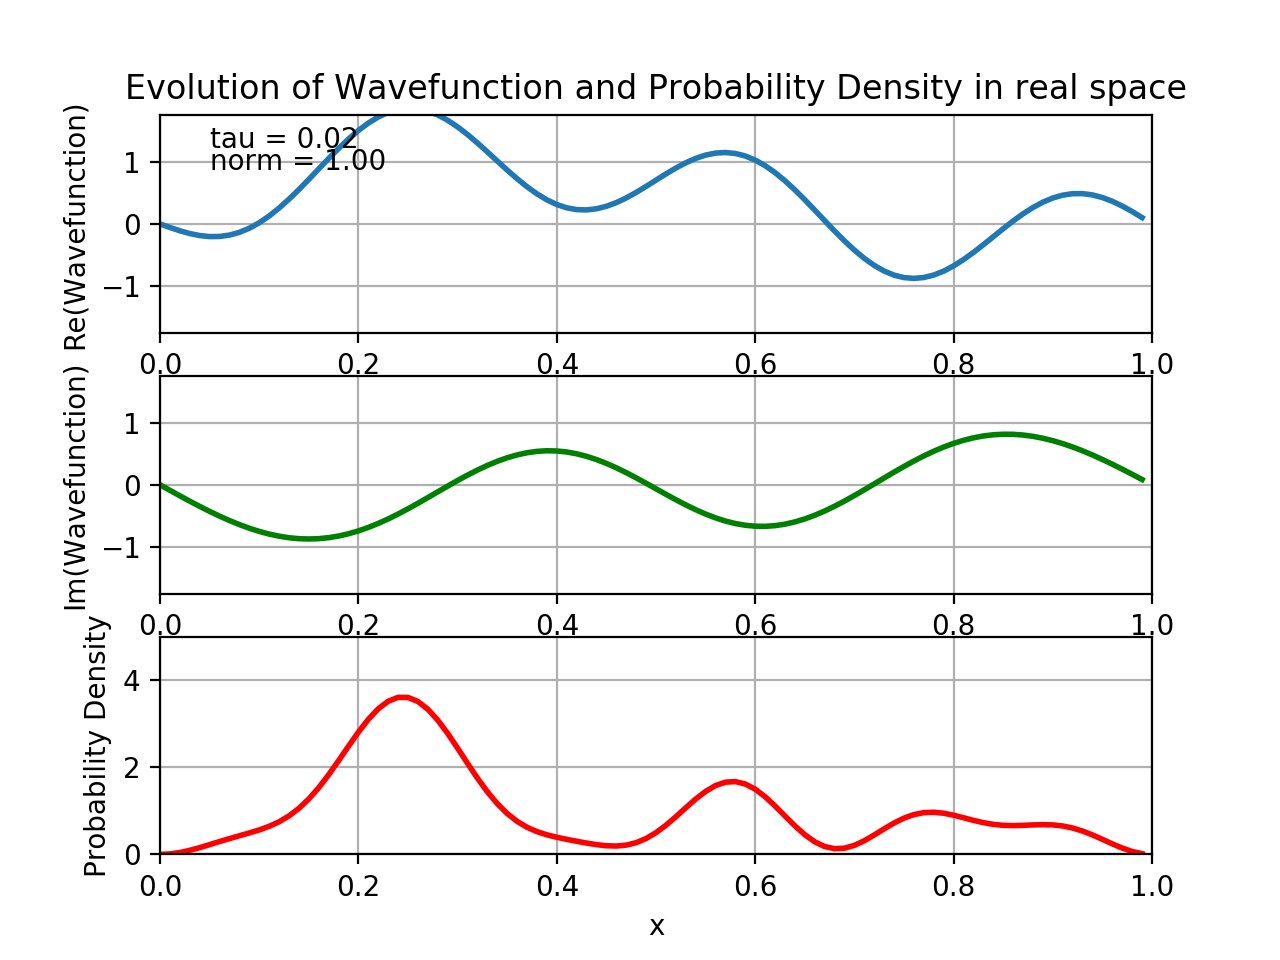

In [9]:
import matplotlib.animation as animation
  
    
# create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='g')
line3, = ax3.plot([], [], lw=2, color='r')
line = [line1, line2, line3]

# the same axes initalizations as before (just now we do it for both of them)
ax1.set_ylim(-1.75, 1.75)
ax1.set_xlim(0, 1)
ax1.grid()
ax1.set_ylabel("Re(Wavefunction)")
ax1.set_title("Evolution of Wavefunction and Probability Density in real space")

ax2.set_ylim(-1.75, 1.75)
ax2.set_xlim(0, 1)
ax2.grid()
ax2.set_ylabel("Im(Wavefunction)")

ax3.set_ylim(0, 5)
ax3.set_xlim(0, 1)
ax3.grid()
ax3.set_xlabel("x")
ax3.set_ylabel("Probability Density")

time_text = ax1.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax1.transAxes)
norm_text = ax1.text(0.05, 0.85,'',horizontalalignment='left',verticalalignment='top', transform=ax1.transAxes)
time_per_frame = 0.0001     # You could change this to make the animation faster or slower

def run_init():
    line[0].set_data([], [])
    line[1].set_data([], [])
    line[2].set_data([], [])
    return line,
    
def run(i):
    wf = wavefunction(x, time_per_frame*i, cn)
    y1data = numpy.real(wf)
    y2data = numpy.imag(wf)
    y3data = numpy.conjugate(wf)*wf

    # update the data of the three line objects
    line[0].set_data(x, y1data)
    line[1].set_data(x, y2data)
    line[2].set_data(x, y3data)
    #Display the current animation time
    time_text.set_text('tau = %.2f' % (i*time_per_frame))
    norm_text.set_text('norm = %.2f' % (norm(spacing,wf)))
    return line, time_text, norm_text

ani = animation.FuncAnimation(fig, run, init_func=run_init,
                               frames=1000, interval=20, blit=True)
    
plt.show()

#### Question 5
Modify the coefficient array, $c_n$, up above so that you are animating a single energy eigenstate. Describe what the animations of $Re[\Psi(x,\tau)]$, $Im[\Psi(x,\tau)]$, and the probability density, $|\Psi(x,\tau)|^2$ look like.  After that, feel free to play around with the coefficients to get all sorts of funky superposition behavior.

### To Momentum Space! Animating $\Psi(k,\tau)$

For our last trick, we'll use NumPy's Fast Fourier Transform method to animate everything in momentum space. ( $Re[\Psi(k,\tau)]$, $Im[\Psi(k,\tau)]$, $|\Psi(k,\tau)|^2$)  You don't need to write any code here, just observe the behavior of the probability density in momentum space. If you want to understand how the NumPy's Fourier transform works, check out https://docs.scipy.org/doc/numpy/reference/routines.fft.html

<IPython.core.display.Javascript object>


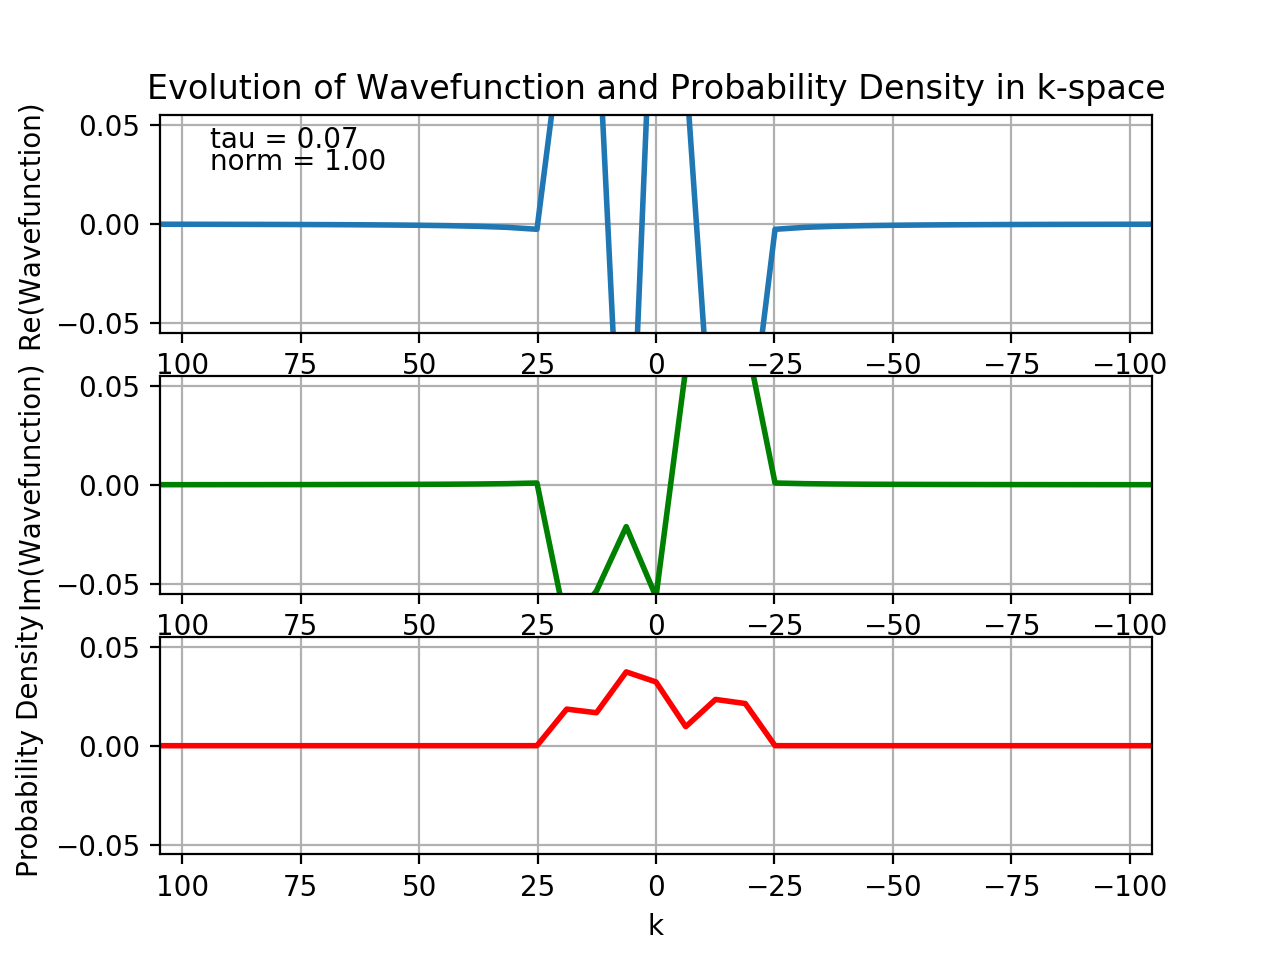

In [10]:
#Define our discrete momentum grid
dk = 2 * numpy.pi / (N * spacing)
k0 = -numpy.pi / spacing
k=2*numpy.pi*numpy.fft.fftfreq(N,d=spacing)

# create a figure with two subplots
figk, (ax1k, ax2k, ax3k) = plt.subplots(3,1)

# intialize two line objects (one in each axes)
line1k, = ax1k.plot([], [], lw=2)
line2k, = ax2k.plot([], [], lw=2, color='g')
line3k, = ax3k.plot([], [], lw=2, color='r')
linek = [line1k, line2k, line3k]

# the same axes initalizations as before (just now we do it for both of them)
#ax1k.set_ylim(-0.2,0.2)
ax1k.set_xlim(-k0/3, k0/3)
ax1k.grid()
ax1k.set_ylabel("Re(Wavefunction)")
ax1k.set_title("Evolution of Wavefunction and Probability Density in k-space")

#ax2k.set_ylim(-0.2,0.2)
ax2k.set_xlim(-k0/3, k0/3)
ax2k.grid()
ax2k.set_ylabel("Im(Wavefunction)")

#ax3k.set_ylim(0, 0.05)
ax3k.set_xlim(-k0/3,k0/3)
ax3k.grid()
ax3k.set_xlabel("k")
ax3k.set_ylabel("Probability Density")

# Add the current animation time and the current wavefunction norm to the plot
time_textk = ax1k.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax1k.transAxes)
norm_textk = ax1k.text(0.05, 0.85,'',horizontalalignment='left',verticalalignment='top', transform=ax1k.transAxes)
time_per_frame = 0.001

def run_initk():
    linek[0].set_data([], [])
    linek[1].set_data([], [])
    linek[2].set_data([], [])
    return line,
    
def runk(i):
    #Get the wavefunction at the current time
    wf = wavefunction(x, time_per_frame*i, cn)
    #Fourier transform the wavefunction into momentum space
    wfk = spacing*numpy.exp(1j*k*x[0])/numpy.sqrt(2*numpy.pi)*numpy.fft.fft(wf)
    
    k_shift = numpy.fft.fftshift(k)
    wfk_shift = numpy.fft.fftshift(wfk)
    
    y1datak = numpy.real(wfk_shift)
    y2datak = numpy.imag(wfk_shift)
    y3datak = numpy.conjugate(wfk_shift)*wfk_shift

    # update the data of the three line objects

    linek[0].set_data(k_shift, y1datak)
    linek[1].set_data(k_shift, y2datak)
    linek[2].set_data(k_shift, y3datak)
    
    #Display the current animation time
    time_textk.set_text('tau = %.2f' % (i*time_per_frame))
    norm_textk.set_text('norm = %.2f' % (norm(dk,wfk)))
    return linek, time_textk, norm_textk

anik = animation.FuncAnimation(figk, runk, init_func=run_initk,
                               frames=1000, interval=20, blit=True)
    
plt.show()

#### Question 6
Observe the momentum space probability distribution for an energy eigenstate. Based on what you see, would you always measure the same momentum in such a state? Are energy eigenstates also momentum eigenstates?